In [1]:
# Robot
# 20 x 21
# Best to be 20cm away for image recognition

# Obstacle
# 10 x 10
# Image will be on either of the 4 cardinal directions

# Grid
# Each square will represent a 10x10 square

# Dubins script source: https://github.com/FelicienC/RRT-Dubins

In [3]:
# Calculating Dubins Path (CSC)
# Major points in the path
# Start Position, End Position, Alpha (Point on current turning circle to stop), Beta (Point on target turning circle to stop)
# Extra points needed: Center point of both turning circles (Pt1 and Pt2)


# RSR and LSL Types
# Straight line dist = ( (Pt2[x] - Pt1[x])**2 + (Pt2[y] - Pt1[y])**2 ) ** 0.5

# Vector 1 = Vector from center of start circle to center of end circle = (V1[x], V1[y]) = (Pt2[x]-Pt1[x], Pt2[y]-Pt1[y])
# Vector 2 = Counterclockwise rotation of Vector 1 = (-V1[y], V1[x])

# Alpha[x] = Pt1[x] + (TurningRadius/StraightDist) * Vector 2[x]
# Alpha[y] = Pt1[y] + (TurningRadius/StraightDist) * Vector 2[y]

# Beta[x] = Alpha[x] + V1[x]
# Beta[y] = Alpha[y] + V1[y]


### RSL and LSR Types


In [2]:
from dubins import Dubins
from map import GridMap

import matplotlib.pyplot as plt
import numpy as np
from python_tsp.exact import solve_tsp_dynamic_programming

In [4]:
directions = {
    'North': np.pi/2,
    'East': 2*np.pi,
    'South': (3*np.pi)/2,
    'West': np.pi
}

# Expected orientation of robot when facing obstacle
robotPositions = {
    'N': directions['South'],
    'E': directions['West'],
    'S': directions['North'],
    'W': directions['East']
}

# Positions RC is expected to be in to accurately capture the image of the obstacles
# Obstacle Orientation to RC Position
# North:    Y-Axis + 2, Directions to be South
# East:     X-Axis + 2, Directions to be West
# South:    Y-Axis - 2, Directions to be North
# West:     X-Axis - 2, Directions to be East
def expectedPos(obstacle):
    ax, ay, obsOrient = obstacle

    if obsOrient == 'N': ay += 2
    elif obsOrient == 'E': ax += 2
    elif obsOrient == 'S': ay -= 2
    else: ax -= 2
    
    orient = robotPositions[obsOrient]
    finalPos = (ax, ay, orient)
    return finalPos

def backward(pos):
    ax, ay, robOrient = pos

    if robOrient == robotPositions['N']: ay -= .5
    elif robOrient == robotPositions['E']: ax -= .5
    elif robOrient == robotPositions['S']: ay += .5
    else: ax += .5

    return (ax, ay, robOrient)

In [5]:
# Tester values

obstacleList = [(11, 9, 'S'),
                (7, 15, 'S'),
                (6, 7, 'E'),
                (14, 14, 'E'),
                (1, 14, 'E')]

initPosition = (2, 2, directions['North'])

# First element represents the inital position the RC will be in
positions = [initPosition]

for obs in obstacleList:
    positions.append(expectedPos(obs))

# positions = [initPosition,
#             (11, 7, directions['North']),
#             (7, 13, directions['North']),
#             (8, 7, directions['West']),
#             (16, 14, directions['West']),
#             (1, 14, directions['West'])]

# Possible positions RC will complete its pathing in
finalPositions = [(1, 1, directions['South']),
                  (1, 2, directions['West'])]

In [6]:
map = GridMap([20, 20])
for ob in obstacleList:
    map.setObstacles(ob)

In [7]:
map.printGrid()

['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['.', '.', '.', '.', '.', '.', '.', 'S', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['X', 'E', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', 'E', '.', '.', '.', '.', '.']
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', 

In [8]:
local_planner = Dubins(2.5, .5)

adjMat = []

for start in positions:
    paths = []
    
    if start != initPosition:
        start = backward(start)

    for dst in positions:
        if dst == initPosition or start == dst:
            paths.append(float('inf'))

        else:
            # Tuple: (Total_Dist, Specific_Dist, Pathing)
            pathing = local_planner.dubins_path(start, dst, map)
            paths.append(pathing if pathing else 0)

    if start != initPosition:
        finalPos0 = local_planner.dubins_path(start, finalPositions[0], map)
        finalPos1 = local_planner.dubins_path(start, finalPositions[1], map)

        paths.append(finalPos0 if finalPos0[0] < finalPos1[0] else finalPos1)
        # paths.append(min(local_planner.dubins_path(start, finalPositions[0], map), local_planner.dubins_path(start, finalPositions[1], map)))

    adjMat.append(paths)

c:\Users\hiast\Desktop\School\Y2S2\SC2079 - MDP\SC2079-MDP\Python\Dubins\dubins.py:523: RuntimeWarning: invalid value encountered in double_scalars
  *(4*self.radius**2-(intercenter/2)**2)**.5


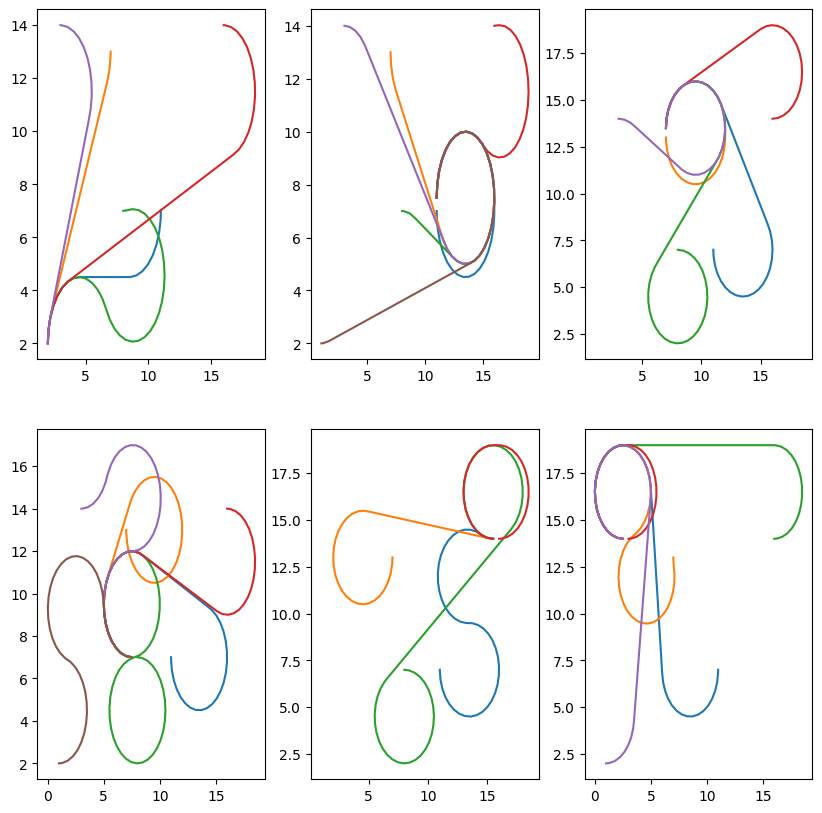

In [9]:
plt.rcParams['figure.figsize'] = [10, 10]

fig, ax = plt.subplots(2, 3)

for path in adjMat[0]:
    if path == float('inf'): continue

    pathing = path[2]
    ax[0, 0].plot(pathing[:, 0], pathing[:, -1])

for path in adjMat[1]:
    if path == float('inf'): continue

    pathing = path[2]
    ax[0, 1].plot(pathing[:, 0], pathing[:, -1])

for path in adjMat[2]:
    if path == float('inf'): continue

    pathing = path[2]
    ax[0, 2].plot(pathing[:, 0], pathing[:, -1])

for path in adjMat[3]:
    if path == float('inf'): continue

    pathing = path[2]
    ax[1, 0].plot(pathing[:, 0], pathing[:, -1])

for path in adjMat[4]:
    if path == float('inf'): continue

    pathing = path[2]
    ax[1, 1].plot(pathing[:, 0], pathing[:, -1])

for path in adjMat[5]:
    if path == float('inf'): continue
    
    pathing = path[2]
    ax[1, 2].plot(pathing[:, 0], pathing[:, -1])

plt.show()

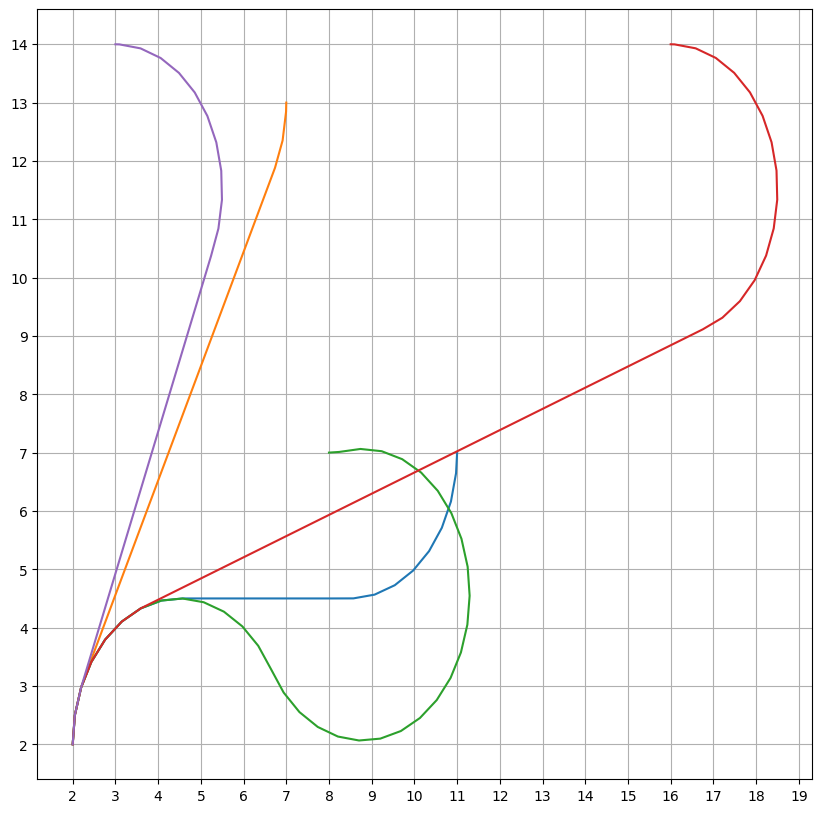

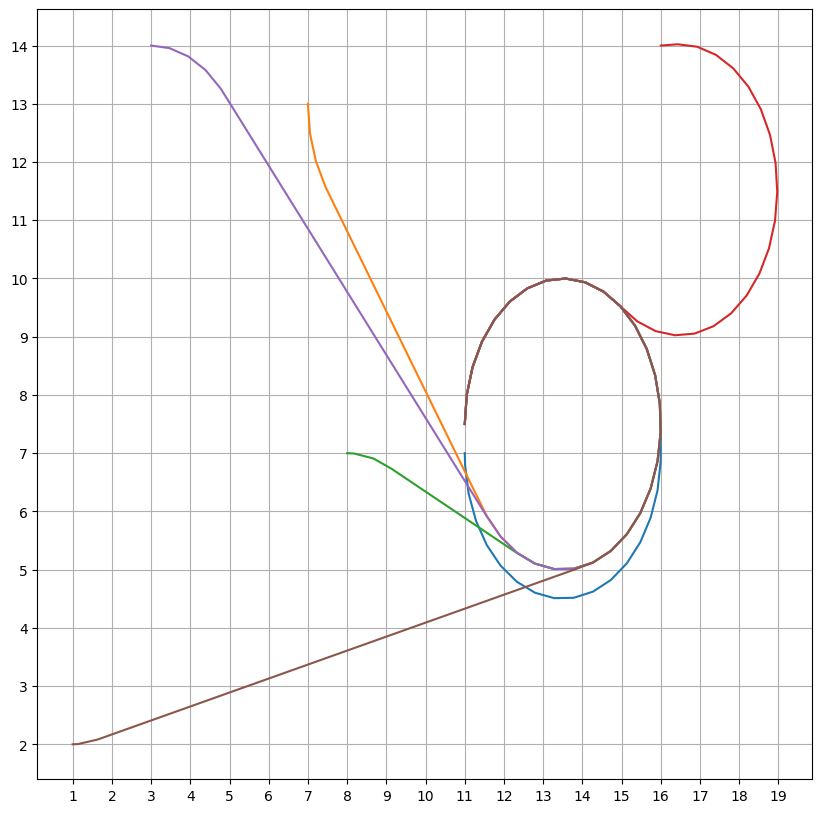

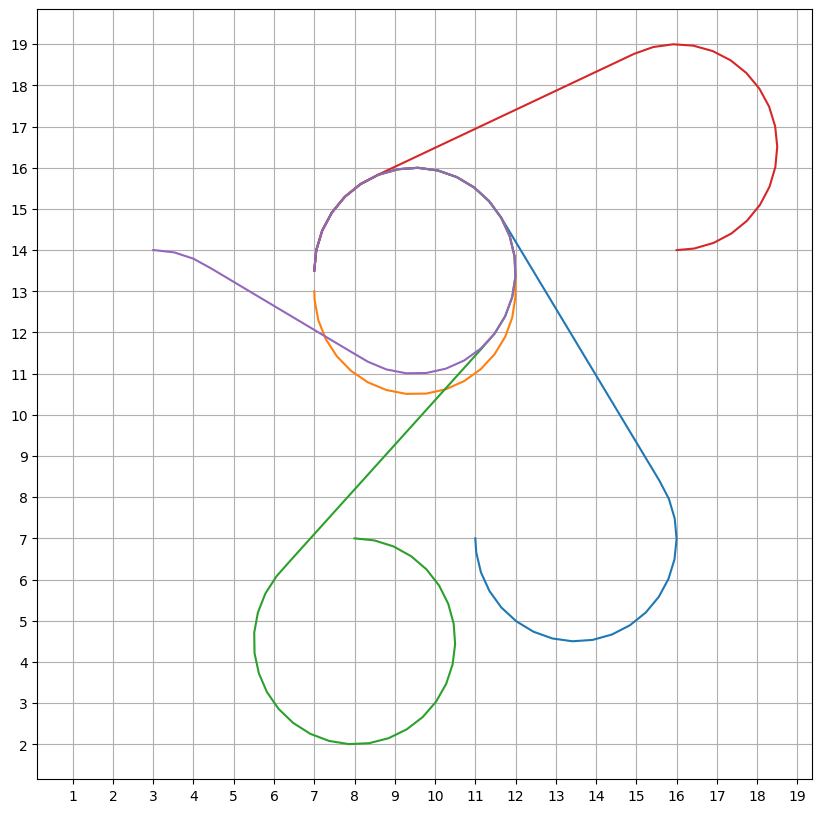

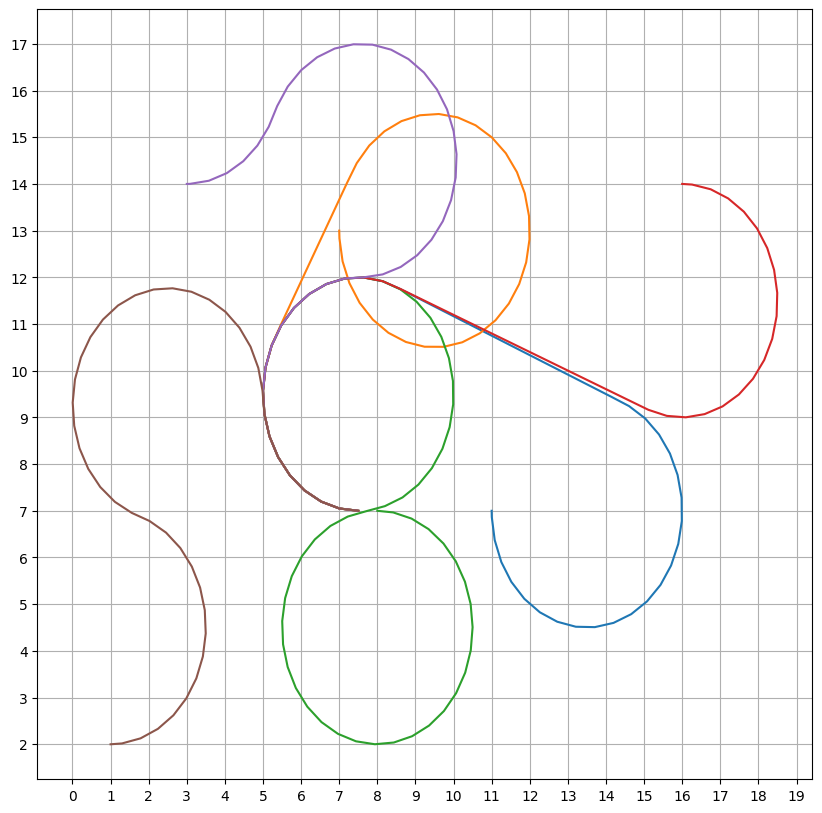

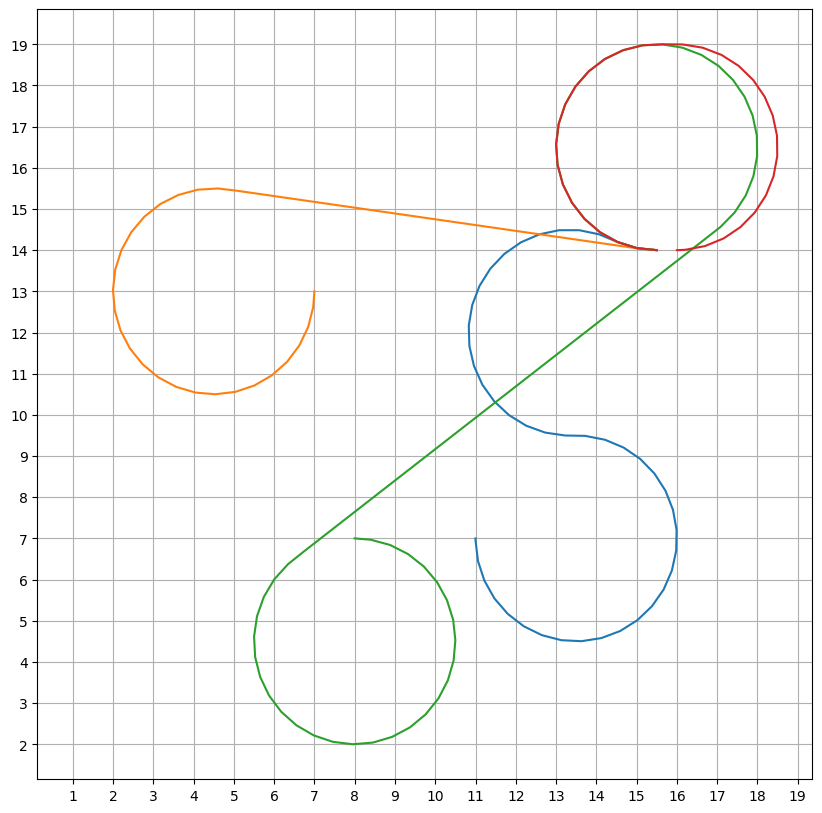

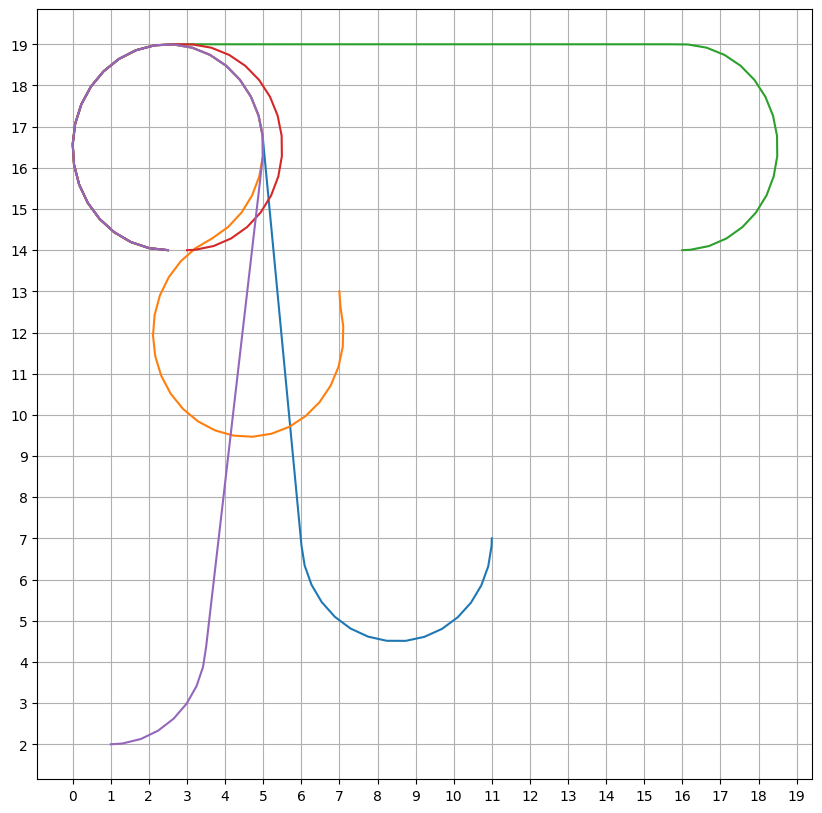

In [11]:
for node in adjMat:
    plt.grid()
    plt.xticks(np.arange(0, 21, 1.0))
    plt.yticks(np.arange(0, 21, 1.0))
    for path in node:
        if path == float('inf'): continue

        pathing = path[2]
        plt.plot(pathing[:, 0], pathing[:, -1])

    plt.show()

In [12]:
adjMatDist = [[path if isinstance(path, float) else path[0] for path in node] for node in adjMat]

for node in adjMatDist:
    print(node)

[inf, 11.853981633974483, 12.15726815753092, 17.739908981456452, 24.09130104588992, 14.093344306550293]
[inf, 16.207963267948966, 22.50869852231669, 17.679723239687814, 15.432279879446543, 25.96901182726925, 24.635932583144164]
[inf, 23.34013202918584, 16.207963267948966, 30.992702973424915, 18.9398829825999, 19.028166300382768, inf]
[inf, 26.134954084936208, 23.666082959085482, 30.919240010986314, 24.759778936314966, 21.58590578915469, 21.800750976438124]
[inf, 22.056465663665804, 22.88494753367341, 41.39879941285102, 16.207963267948966, inf, inf]
[inf, 29.18651737123567, 26.354220538018083, inf, 29.207963267948966, 16.207963267948966, 27.80134989039679]
